In [2]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sbn
import matplotlib.pyplot as plt
from scipy.stats import boxcox

In [3]:
df = pd.read_csv('upa_event_ts.csv')
df = df.sort_values(by=['datetime'])

In [4]:
df.head(2)

,datetime,code,day,hour,minute,day_name,datetime.1,count,date,month
0,1535414421259,combinedproducts-search-e-flightresults-filter...,27,20,0,Monday,1535414421259,1,2018-08-27 20:00:21.259,8
1,1535414451815,transfers-checkout-e-credit-card-completed,27,20,0,Monday,1535414451815,2,2018-08-27 20:00:51.815,8


In [215]:
def get_ts(code,df, apply_box_cox = True, lamb = 0.5):
    values = np.float32(df[df.code == code]['count'].values)
    dim = values.shape[0]
    index = np.int64(np.array([x for x in range(1,dim+1)]))
    index = index.reshape(1,dim)
    values = values.reshape(1,dim)
    if (apply_box_cox):
        values = boxcox(values, lamb)
    return (index, values)

In [353]:
LEARNING_RATE = 1.0
PERIOD = 1008
PI = np.pi
ALPHA_REG = 0
THRESHOLD = 950
TEST = 144*4  #For the las 4 days

In [471]:
x_ts, y_ts = get_ts('activities-checkout',df, apply_box_cox=True, lamb=0.5)
#For train everything except the last four days
x_ts_train = x_ts[:, :-TEST]
y_ts_train = y_ts[:, :-TEST]

# *Modelo de Fourier (para series de tiempo periodicas)*

## $S_{t} = \sum_{k = 1}^{N-1} A_{k}\sin(\frac{2k\pi t}{N}) + \sum_{k = 1}^{N-1} B_{k}\cos(\frac{2k\pi t}{N}) $

### Tambien es posible expresarlo solo con senos poniendo un parametro mas que es la fase
## $S_{t} = \sum_{k = 1}^{N-1} A_{k}\sin(\frac{2k\pi t}{N} + P_{k}) $

### Donde $N$ es la cantidad de mediciones por ciclo de la serie de tiempo. $A_{k}$ y $B_{k}$ son las amplitudes y los parametros en este modelo. En nuestro caso las series de tiempo de upa por lo general tienen dos estacionalidades una diaria y otra semanal. Para poder capturar los dos tipos de estacionalidad $N$ tiene que contemplar la cantidad de mediciones por semana.

### La solucion que proponemos es usar *descenso por el gradiente* para encontrar los parametros optimos usando como funcion objetivo MSE entre el valor de la serie de tiempo y el calculado por el modelo.

### Observamos que el tiempo de entrenamiento es mucho menor si aplicamos la trasnformacion de box-cox a la serie de tiempo ya que esta disminuye ruido de la serie y no perjudica el calculo de las anomalias, es decir las anomalias siguen existiendo en la serie transformada.

### La transformacion de box-cox esta dada por la siguiente ecuacion:

## $ \displaystyle{X}_{\lambda}^{'} = \frac{{X}^{\lambda} - 1}{\lambda}$ 
### Para el caso de $\lambda = 0$ resulta en $log$

## *Armado del grafo en tensorflow y optimizacion de parametros*

In [472]:
x_train = tf.constant(x_ts_train,dtype=tf.float32)

y_train = tf.constant(y_ts_train,dtype=tf.float32)

x = tf.constant(x_ts,dtype=tf.float32)

y = tf.constant(y_ts,dtype=tf.float32)

multipliers = tf.constant([(x*2*PI)/PERIOD for x in range(THRESHOLD,PERIOD)], dtype=tf.float32)

amplitudes_cos = tf.Variable(tf.random_uniform([1, PERIOD - THRESHOLD], -10, 10, seed=42))

phases = tf.Variable(tf.random_uniform([1, PERIOD - THRESHOLD], -10, 10, seed=42))

amplitudes_sin = tf.Variable(tf.random_uniform([1, PERIOD - THRESHOLD], -10, 10, seed=42))

bias = tf.Variable(tf.zeros([1]))

sin_part = tf.reduce_sum(tf.sin(tf.transpose(x_train) * multipliers) * amplitudes_sin, 1)

cos_part = tf.reduce_sum(tf.cos(tf.transpose(x_train) * multipliers) * amplitudes_cos, 1)

y_pred = sin_part + cos_part + bias

error = y_pred - y_train

regularizer = ALPHA_REG * tf.nn.l2_loss(amplitudes_cos) + ALPHA_REG * tf.nn.l2_loss(amplitudes_sin)

mse = tf.reduce_mean(tf.square(error) + regularizer, name="mse")

op = tf.train.AdamOptimizer(learning_rate=LEARNING_RATE).minimize(mse)

#Evaluate the model on future dates
sin_part = tf.reduce_sum(tf.sin(tf.transpose(x) * multipliers) * amplitudes_sin, 1)

cos_part = tf.reduce_sum(tf.cos(tf.transpose(x) * multipliers) * amplitudes_cos, 1)

y_ext = sin_part + cos_part + bias


In [473]:
n_epochs = 400
init = tf.global_variables_initializer()
sess = tf.Session()
with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            sess.run(op)
            print("epoch %s, mse = %s " % (epoch, mse.eval()))
        y_p = y_pred.eval()
        y_extended = y_ext.eval()

epoch 0, mse = 1601.8009 
epoch 1, mse = 1172.7272 
epoch 2, mse = 844.65216 
epoch 3, mse = 602.7668 
epoch 4, mse = 430.32166 
epoch 5, mse = 312.04214 
epoch 6, mse = 234.72522 
epoch 7, mse = 186.69417 
epoch 8, mse = 158.19624 
epoch 9, mse = 142.25838 
epoch 10, mse = 134.5422 
epoch 11, mse = 132.28114 
epoch 12, mse = 133.32065 
epoch 13, mse = 135.70561 
epoch 14, mse = 137.69345 
epoch 15, mse = 137.89195 
epoch 16, mse = 135.32478 
epoch 17, mse = 129.49304 
epoch 18, mse = 120.52077 
epoch 19, mse = 109.16858 
epoch 20, mse = 96.525 
epoch 21, mse = 83.613914 
epoch 22, mse = 71.231094 
epoch 23, mse = 59.992817 
epoch 24, mse = 50.37676 
epoch 25, mse = 42.68433 
epoch 26, mse = 36.99511 
epoch 27, mse = 33.151737 
epoch 28, mse = 30.808207 
epoch 29, mse = 29.541897 
epoch 30, mse = 28.952694 
epoch 31, mse = 28.702284 
epoch 32, mse = 28.532694 
epoch 33, mse = 28.27509 
epoch 34, mse = 27.813625 
epoch 35, mse = 27.040989 
epoch 36, mse = 25.878664 
epoch 37, mse = 24.3

epoch 319, mse = 7.411118 
epoch 320, mse = 7.4111176 
epoch 321, mse = 7.4111176 
epoch 322, mse = 7.4111176 
epoch 323, mse = 7.4111176 
epoch 324, mse = 7.4111176 
epoch 325, mse = 7.4111166 
epoch 326, mse = 7.411118 
epoch 327, mse = 7.4111176 
epoch 328, mse = 7.4111166 
epoch 329, mse = 7.4111176 
epoch 330, mse = 7.4111166 
epoch 331, mse = 7.4111166 
epoch 332, mse = 7.4111166 
epoch 333, mse = 7.4111166 
epoch 334, mse = 7.4111166 
epoch 335, mse = 7.411118 
epoch 336, mse = 7.411118 
epoch 337, mse = 7.4111166 
epoch 338, mse = 7.4111166 
epoch 339, mse = 7.411118 
epoch 340, mse = 7.411118 
epoch 341, mse = 7.4111166 
epoch 342, mse = 7.4111166 
epoch 343, mse = 7.4111166 
epoch 344, mse = 7.4111176 
epoch 345, mse = 7.4111166 
epoch 346, mse = 7.411118 
epoch 347, mse = 7.4111166 
epoch 348, mse = 7.4111166 
epoch 349, mse = 7.4111176 
epoch 350, mse = 7.4111166 
epoch 351, mse = 7.4111166 
epoch 352, mse = 7.4111176 
epoch 353, mse = 7.411118 
epoch 354, mse = 7.4111176 


## *Calculo del ruido*

In [474]:
noise = y_ts_train - y_p

/Users/claudio.gauna/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


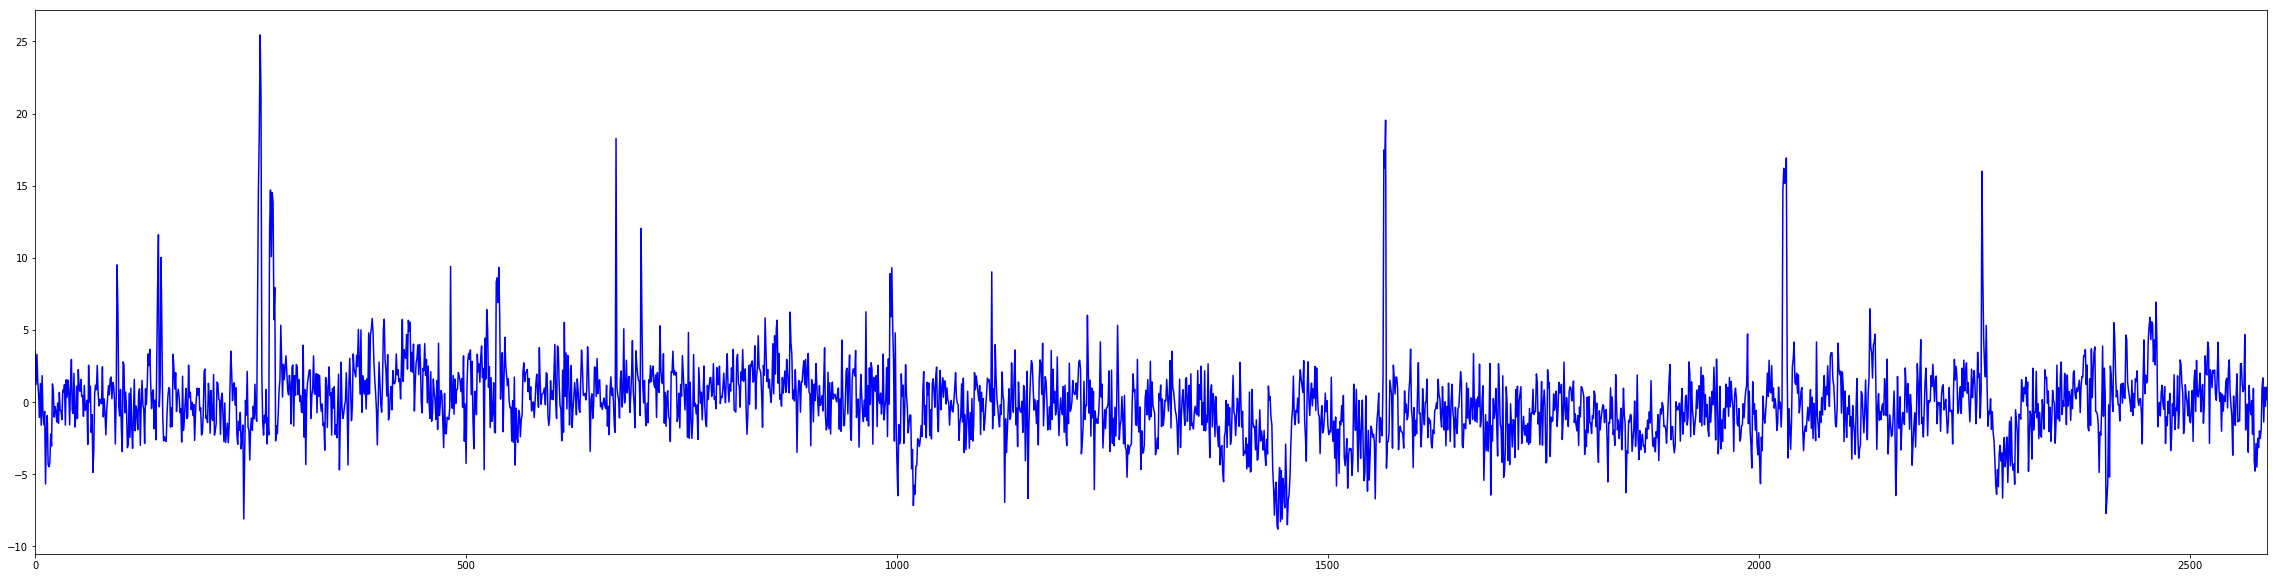

In [475]:
plt.figure(figsize=(40,10))
sbn.tsplot(noise, color="blue")

## *Calculo de anomalias*

In [476]:
sigma = np.sqrt(np.var(y_ts_train - y_p))

In [477]:
anomalies_index = np.argwhere(np.abs(noise) - 2.5*sigma > 0)

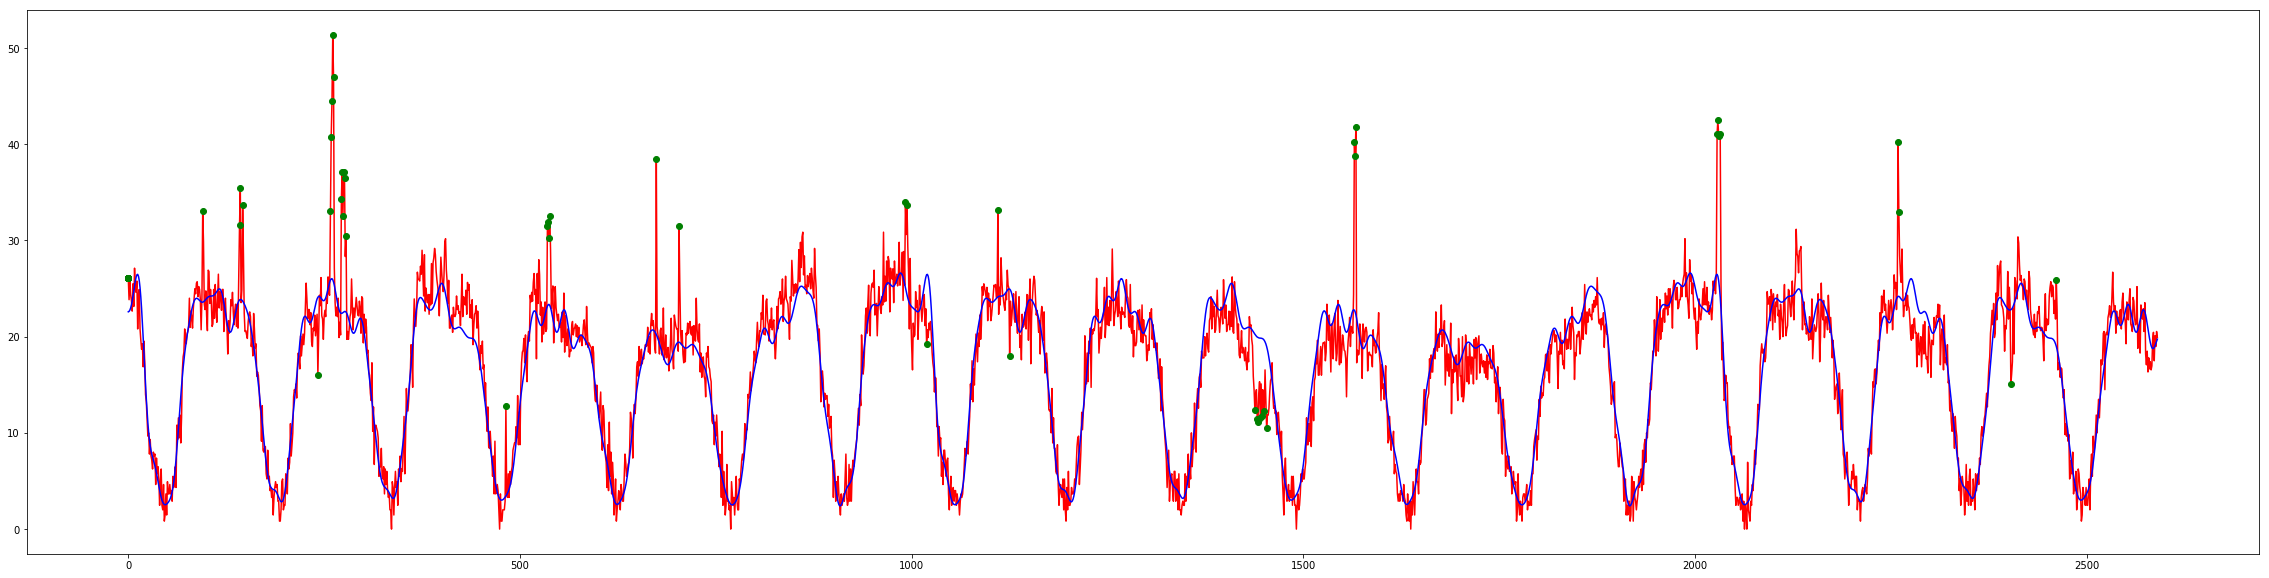

In [478]:
plt.figure(figsize=(40,10))
plt.plot(y_ts_train[0,:],"-r")
plt.plot(y_p, "-b")
plt.plot(anomalies_index, y_ts_train[0,anomalies_index], "og")

## *Forecasting para 4 dias*

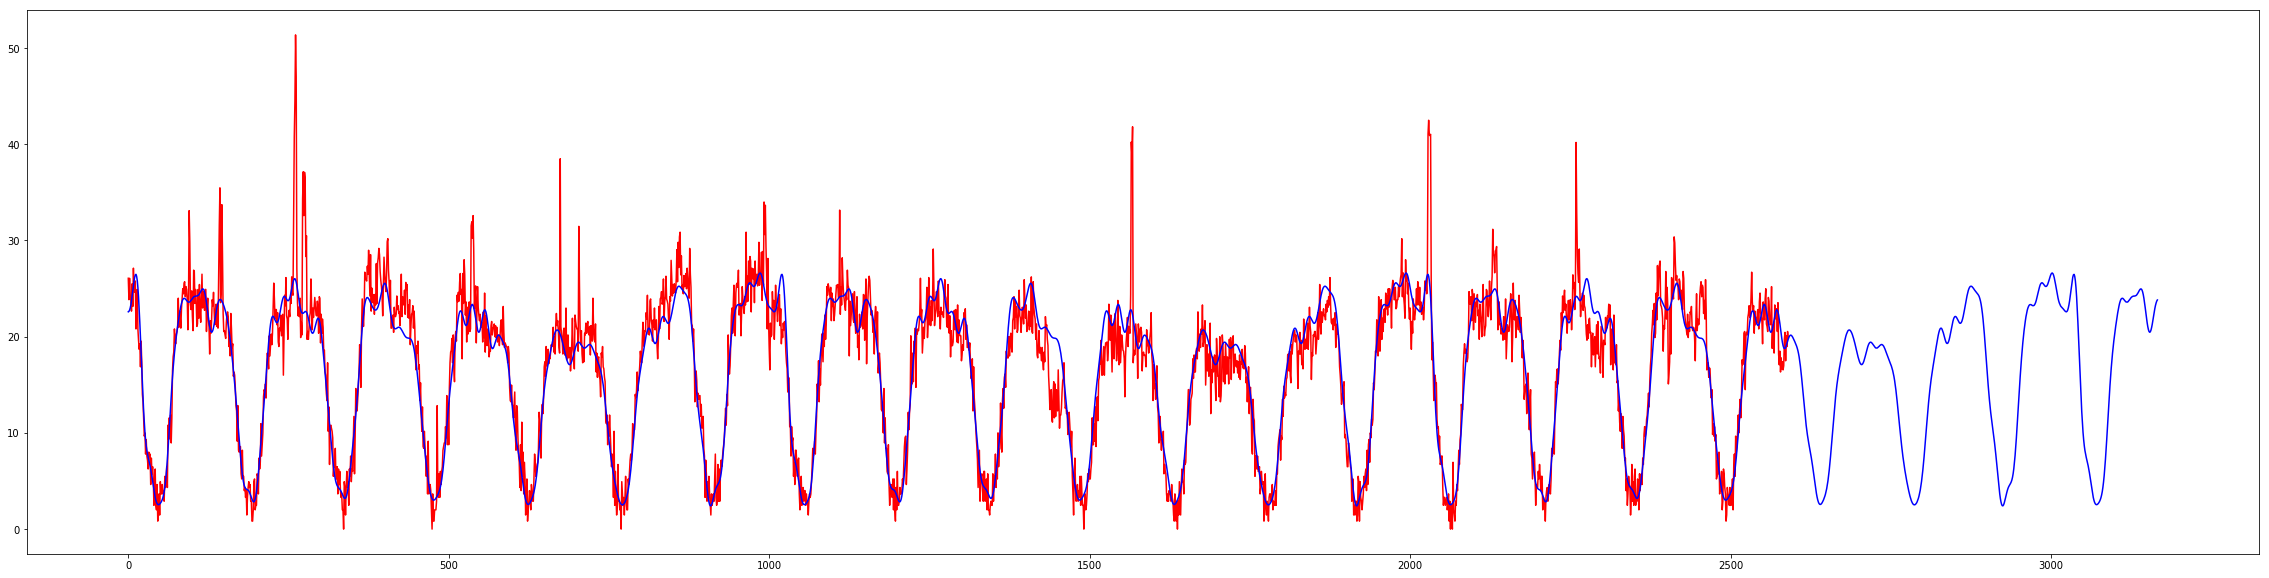

In [479]:
plt.figure(figsize=(40,10))
plt.plot(y_ts_train[0,:],"-r")
plt.plot(y_extended, "-b")